# Assignment 4 - AirBnB

First, I will prepare the data. I will normalize all and obtain two sets, the train set and the test set. Both elected randomly and with n = 1000.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy.stats import norm
import numpy as np
from sklearn import preprocessing
import scipy.cluster.hierarchy as sch
from sklearn.cluster import *
import seaborn as sns


filename_tsv = "data/listings.csv"

tsv_read = pd.read_csv(filename_tsv)

latitude = list(tsv_read.latitude)
longitude = list(tsv_read.longitude)
tot_mean_lat = tsv_read.latitude.mean()
tot_mean_long = tsv_read.longitude.mean()
tot_sd_lat = tsv_read.latitude.std()
tot_sd_long = tsv_read.longitude.std()

''' I normalize the data because if I do not do it, I get a too small SD and cannot execute well the classifier'''

tsv_read.latitude = (tsv_read.latitude - tot_mean_lat)/tot_sd_lat
tsv_read.longitude = (tsv_read.longitude - tot_mean_long)/tot_sd_long


test = tsv_read.sample(n=1000)

#This line gets rid of the last 1000 rows that I selected in order to don't get the same row in the train set and 
# in the test set.
tsv_read = pd.concat([tsv_read, test]).drop_duplicates(keep=False)

train = tsv_read.sample(n=1000)



In [3]:
neighbourhoods = set(list(tsv_read.neighbourhood_group))

#Grouping and calculating the mean and sd of training set 

mean = train.groupby(['neighbourhood_group']).mean()
sd = train.groupby(['neighbourhood_group']).std()

#Getting in a dict the mean and sd for each property (lat, long)

latitudes = {'mean' : dict(mean.latitude),\
             'sd' : dict(sd.latitude)}

longitudes = {'mean' : dict(mean.longitude),\
              'sd' : dict(sd.longitude)}

props = ['longitudes', 'latitudes']

probabilities = {}
probabilities['latitude'] = {}
probabilities['longitude'] = {}

ocurrencies = {}

def distributionProbFunction(neighbourhood, metric):
    ''' Calculating the prob function'''
    if(metric == 'longitudes'):

        return lambda x: norm.pdf(x, longitudes['mean'][neighbourhood] , longitudes['sd'][neighbourhood])
    return lambda x: norm.pdf(x, latitudes['mean'][neighbourhood] , latitudes['sd'][neighbourhood])

''' 
    This iteration is for storing the probabilities of obtaining the class for each one. I am also calculating 
    the number of ocurrencies for each class in my training set.
'''
for neighbor in neighbourhoods:
    probabilities['latitude'][neighbor] = distributionProbFunction(neighbor, 'latitudes')
    probabilities['longitude'][neighbor] = distributionProbFunction(neighbor, 'longitudes')
    ocurrencies[neighbor] = train['neighbourhood_group'].value_counts()[neighbor]
'''
This function is the last step, predicting the values. Is used with the test rows, and it already knows the probabilities
for each class calculated in the last step.
'''
def predict(vector):
    p = {}

    for neighbor in neighbourhoods:
        distributions = [distributionProbFunction(neighbor,prop)(vector[i]) \
                           for i,prop in enumerate(props)], 

        product = np.prod(distributions)

        p[neighbor] = ocurrencies[neighbor]*product

    results = [(p[neighbor],neighbor) for neighbor in neighbourhoods]
    results.sort()
    return results[-1][1], results[-1][0]/sum([r[0] for r in results])


The next function is only for predict several values iterating over a dataframe

In [4]:

def getPredictions(testSet):
    predictions = []
    for index, row in testSet.iterrows(): 
        result = predict([row.latitude, row.longitude])
        predictions.append(result)
    return predictions

In [5]:
def getAccuracy(testSet):
    
    cont = 0
    predictions = []
    for index, row in testSet.iterrows(): 
        result = predict([row.latitude, row.longitude])
        if result[0] == row.neighbourhood_group:
            cont += 1
            
    return (cont / float(len(testSet))) * 100.0

In [6]:
getAccuracy(test)

33.800000000000004

2) We want to clusterize the apartments according to their prize and room type (1: shared room, 2: private room, 3: hotel room, 4: entire apartment). Plotting different amount of clusters according to this and other features (neighbourhood, availability, minimum nights) can we draw any conclusions?


## K-Means

[[0.00402763 0.67152009 0.10876529]
 [0.01488704 0.02243912 0.10707622]
 [0.00757239 0.38440908 0.83538947]]


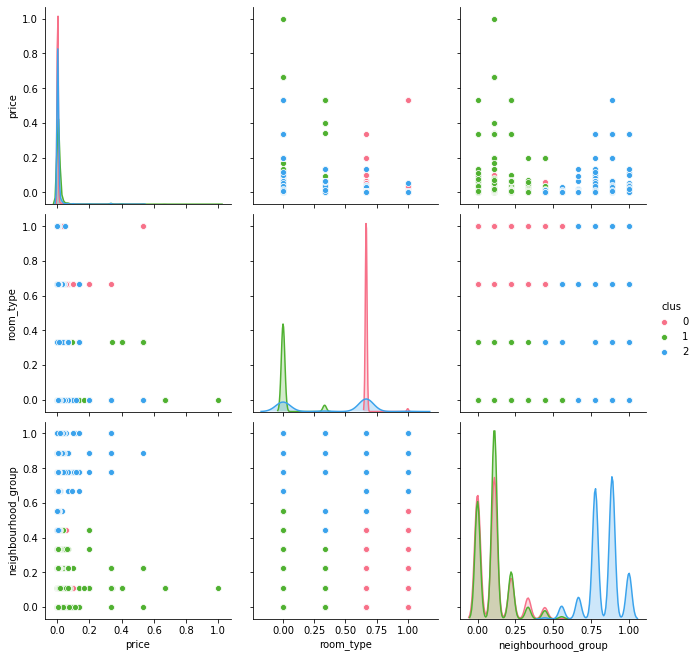

In [7]:

df_2 = pd.DataFrame(columns=['price','room_type','neighbourhood_group'])

df_2 = tsv_read[['price','room_type','neighbourhood_group']].copy()

df_2.room_type = pd.Categorical(df_2.room_type) 
df_2.room_type = df_2.room_type.cat.codes

df_2.neighbourhood_group = pd.Categorical(df_2.neighbourhood_group) 
df_2.neighbourhood_group = df_2.neighbourhood_group.cat.codes

x = df_2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_2 = pd.DataFrame(x_scaled,columns=df_2.columns)

kmeans = KMeans(n_clusters=3).fit(df_2)
centroids = kmeans.cluster_centers_
print(centroids)

df_2['clus'] = kmeans.labels_

sns.pairplot(data= df_2, hue="clus", palette="husl", height=3)


Here we see that K-Means made the clusters taking into account a lot the neighbourhood groups. We also see that it did ot classify well between the different prices, but it did well for the room types for 2 clusters. 

It can be seen that the red cluster is mostly on two room types and tend to have smaller prices. This is because shared rooms and private rooms are usually cheaper than a entire apartment or an hotel room. The "antagonist" cluster, the green one, have these other types of rooms and the prices are a little higher. 

## MeanShift

In [8]:
df_shift = pd.DataFrame(columns=['price','room_type','neighbourhood_group'])

df_shift = tsv_read[['price','room_type','neighbourhood_group']].copy()

df_shift.room_type = pd.Categorical(df_shift.room_type) 
df_shift.room_type = df_shift.room_type.cat.codes

df_shift.neighbourhood_group = pd.Categorical(df_shift.neighbourhood_group) 
df_shift.neighbourhood_group = df_shift.neighbourhood_group.cat.codes

x = df_shift.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_shift = pd.DataFrame(x_scaled,columns=df_shift.columns)

In [13]:
bandwidth = estimate_bandwidth(df_shift, quantile=0.5, n_samples=50)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms = ms.fit_predict(df_shift)

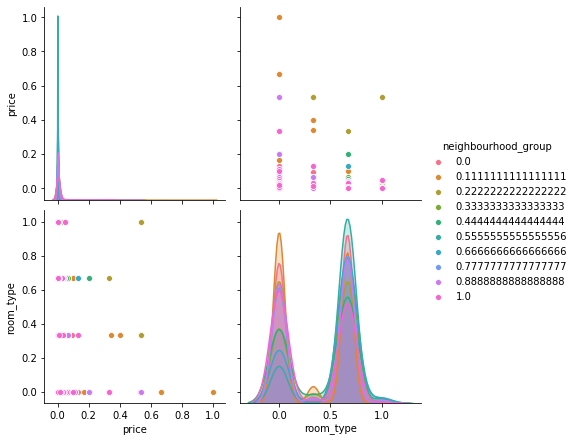

In [14]:

sns.pairplot(data= df_shift, hue="neighbourhood_group",palette="husl", height=3)